In [1]:
import h5py 
import numpy as np
import tiledb
import threading
import time
import threading


class Slicer:
    # default 引数
    def __init__(self,blockOffset=256,filename="/scratch/aoyagir/step1_256_test_0902.h5") -> None:
        self.filename = filename
        self.blockOffset = blockOffset
        self.file = h5py.File(filename, 'r')
        self.dataset = self.file['data']
        self.timesteps = self.dataset.shape[0]
        self.xMax = self.dataset.shape[1]
        self.yMax = self.dataset.shape[2]
        self.zMax = self.dataset.shape[3]
        self.lock = threading.Lock()
        self.printDataInfo()

    # Access specific elements in the concatenated array
    def access_array_element(self,timestep, x, y, z):
        element = self.dataset[timestep, x, y, z]
        return element

    # Access a subset of the concatenated array
    def slice_multiple_step(self, file, timestep_start, timestep_end, x_start, x_end, y_start, y_end, z_start, z_end):
        subset = self.dataset[timestep_start:timestep_end, x_start:x_end, y_start:y_end, z_start:z_end]
        return subset
    
    def slice_single_step(self, timestep,  x_start, x_end, y_start, y_end, z_start, z_end):
        subset = self.dataset[timestep,  x_start:x_end, y_start:y_end, z_start:z_end]
        retsubset = np.squeeze(subset)
        return retsubset
    
    # blockId = (tol,timestep,x,y,z)
    def sliceData(self,blockId):
        # with self.lock:
        _ = blockId[0]
        t = blockId[1]
        x = blockId[2]
        y = blockId[3]
        z = blockId[4]
        return self.slice_single_step(t,x,x+self.blockOffset,y,y+self.blockOffset,z,z+self.blockOffset)

    def changeBlockSize(self,blockSize):
        print("changin block size from {} to {}".format(self.blockOffset,blockSize))
        self.blockOffset = blockSize
    
    def printBlocksize(self):
        print(self.blockOffset)

    def printDataInfo(self):
        print("##### Row data INFO #####")
        print("timesteps:{}\nx:{}\ny:{}\nz:{}\n"
              .format(self.timesteps,self.xMax,self.yMax,self.zMax))
        
    def getDataDim(self):
        return self.dataset.shape


class TileDBSlicer:
    #/scratch/aoyagir/tiledb_data/array64
    def __init__(self,blockOffset=256,cacheSize=0,filename="/scratch/aoyagir/tiledb_data/array64") -> None:
        # Create a TileDB config
        self.config = tiledb.Config()
        self.ctx = tiledb.Ctx(self.config)
        self.filename = filename
        self.blockOffset = blockOffset
        self.timesteps = None
        self.xMax = None
        self.yMax = None
        self.zMax = None
        self.getDim()
        self.printDataInfo()


    def printDataInfo(self):
        print("##### Row data INFO #####")
        print("timesteps:{}\nx:{}\ny:{}\nz:{}\n"
              .format(self.timesteps,self.xMax,self.yMax,self.zMax))

    def getDim(self):
        with tiledb.open(self.filename, mode="r", ctx=self.ctx) as array:
            # Retrieve and print the array schema
            array_schema = array.schema
            print("Array Schema:")
            print(array_schema)
            # You can also access other information about the array, such as its domain and attributes
            domain = array_schema.domain
            print("Domain:", domain)

    def get(self,timestep,x,xx,y,yy,z,zz):
        with tiledb.DenseArray(self.filename, mode="r", ctx=self.ctx) as array:
            # Read the sliced data from the TileDB array using 'from' and 'to' expressions
            # arrayから返却されるのは、orderd_dict.で、keyが'data'になっているので読みだす必要がある。
            # 以下で、dataが読み出される。
            data = array[timestep,x:xx, y:yy, z:zz]['data']
            return data







In [2]:
import concurrent.futures
class TileDBReaderThread(threading.Thread):
    def __init__(self):
        super().__init__()
        self.tiledb_reader = TileDBSlicer()

    def run(self):
        a = self.tiledb_reader.get(0, 0, 256, 0, 256, 0, 256)
        dim = self.tiledb_reader.getDim()
        print(dim)
        for _ in range(100):
            s = time.time()
            a = self.tiledb_reader.get(0, 0, 256, 0, 256, 0, 256)
            e = time.time()
            print(e - s)
        print(a)

import random
import copy
# test
class TileDBReader:
    def __init__(self):
        self.tiledb_reader = TileDBSlicer()

    def read_and_measure(self, thread_id):
        print(f"Hi ! this is thread {thread_id} from tiledb")
        a = self.tiledb_reader.get(0, 0, 256, 0, 256, 0, 256)
        i = copy.deepcopy(thread_id)
        i %= 3
        read_time = []
        total_data = 0
        for _ in range(50):
            random_number = random.randrange(0, 64)
            s = time.time()
            try:
                a = self.tiledb_reader.get(random_number, i*256, i*256 + 256, i*256, i*256 + 256, i*256, i*256 + 256)
            except Exception as e:
                print(e)
            e = time.time()
            read_time.append(e-s)
            total_data += a.nbytes/1024/1024
        
        print("tot:",total_data,"MiB")
        return read_time

class HDF5Reader:
    def __init__(self):
        self.hdf5_reader = Slicer()

    def read_and_measure(self, thread_id):
        a = self.hdf5_reader.sliceData((0.1, 0, 0, 0, 0))

        read_time = []
        total_data = 0
        for _ in range(50):
            random_number = random.randrange(0, 64)
            s = time.time()
            a = self.hdf5_reader.sliceData((0.1, random_number,0,0,0))
            e = time.time()
            read_time.append(e-s)
            total_data += a.nbytes/1024/1024
        print("tot:",total_data,"MiB")
        return read_time




In [16]:
num_threads = 4  # Adjust the number of threads as needed
tiledb_readers = [TileDBReader() for _ in range(num_threads)]
hdf5_readers = [HDF5Reader() for _ in range(num_threads)]

# Create lists to store the Future objects
tiledb_futures = []
hdf5_futures = []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(num_threads):
        print(f"executing thread:{i}")
        tiledb_futures.append(executor.submit(tiledb_readers[i].read_and_measure, i))

print("HDF5 scalability")

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for i in range(num_threads):
        hdf5_futures.append(executor.submit(hdf5_readers[i].read_and_measure, i))

# Now you can retrieve the results from the Future objects
tiledb_results = [future.result() for future in tiledb_futures]
hdf5_results = [future.result() for future in hdf5_futures]


Array Schema:
ArraySchema(
  domain=Domain(*[
    Dim(name='timestep', domain=(0, 63), tile=1, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
    Dim(name='x', domain=(0, 1023), tile=256, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
    Dim(name='y', domain=(0, 1023), tile=256, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
    Dim(name='z', domain=(0, 1023), tile=256, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
  ]),
  attrs=[
    Attr(name='data', dtype='float32', var=False, nullable=False, enum_label=None),
  ],
  cell_order='row-major',
  tile_order='row-major',
  sparse=False,
)

Domain: Domain(Dim(name='timestep', domain=(0, 63), tile=1, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
       Dim(name='x', domain=(0, 1023), tile=256, dtype='uint64', filters=FilterList([ZstdFilter(level=-1), ])),
       Dim(name='y', domain=(0, 1023), tile=256, dtype='uint64', filters=FilterList([ZstdFilter(level=-1

In [17]:
tiledb_concated = []
hdf5_concated = []
for thread_id in range(num_threads):
    print("average:",np.average(tiledb_results[thread_id]))
    print("std_dev:",np.std(tiledb_results[thread_id]))
    tiledb_concated += tiledb_results[thread_id]
    hdf5_concated += hdf5_results[thread_id]

average: 0.196191029548645
std_dev: 0.03398160300912249
average: 0.19467427730560302
std_dev: 0.030636574091938627
average: 0.19345497131347655
std_dev: 0.02845033817527618
average: 0.1983531379699707
std_dev: 0.025598131465584144


In [18]:
print("hdf5 avg:",np.average(hdf5_concated))
print("hdf5 std:",np.std(hdf5_concated))
print("tiledb svg:",np.average(tiledb_concated))
print("tiledb std:",np.std(tiledb_concated))

hdf5 avg: 0.4664522123336792
hdf5 std: 0.012583772048028304
tiledb svg: 0.19566835403442384
tiledb std: 0.0298806107620948


In [47]:
num_threads = [1,2,4,8,16,32]
hdf5_avg = [0.107,0.22421,0.4664,4.0978]
hdf5_std = [0.00603,0.00788,0.01258,1.488]
tiledb_avg = [0.112490,0.14739,0.19566,1.0386]
tiledb_std = [0.01003,0.0143200,0.029880,0.3593]

In [58]:
bandWidth_bytes = 2*1024*1024*1024*1024
MiB_per_read = 64*1024*1024
ideal_read_time = []
for n_thred in (num_threads):
    ideal_read_time.append(MiB_per_read/(bandWidth_bytes/n_thred))

print(ideal_read_time)



[3.0517578125e-05, 6.103515625e-05, 0.0001220703125, 0.000244140625, 0.00048828125, 0.0009765625]


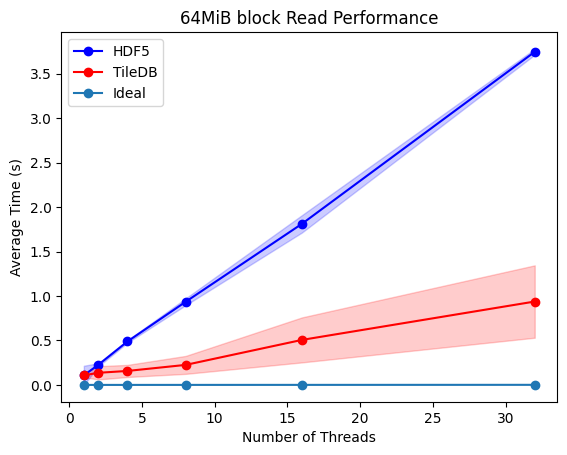

In [59]:
import matplotlib.pyplot as plt

# Data
num_threads = [1,2,4,8,16,32]
hdf5_avg = [0.1079,0.2264,0.4889,0.935,1.812224,3.7461]
hdf5_std = [0.1079,0.0178,0.01302,0.0385,0.09766,0.03262]
tiledb_avg = [0.1079,0.1364,0.1572,0.2252,0.50635,0.93784]
tiledb_std = [0.0226,0.07440,0.06809,0.1009,0.25305909,0.4070]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot HDF5 data with range
ax.plot(num_threads, hdf5_avg, marker='o', label='HDF5', color='b', linestyle='-')
ax.fill_between(num_threads, [avg - std for avg, std in zip(hdf5_avg, hdf5_std)],
                [avg + std for avg, std in zip(hdf5_avg, hdf5_std)], alpha=0.2, color='b')

# Plot TileDB data with range
ax.plot(num_threads, tiledb_avg, marker='o', label='TileDB', color='r', linestyle='-')
ax.fill_between(num_threads, [avg - std for avg, std in zip(tiledb_avg, tiledb_std)],
                [avg + std for avg, std in zip(tiledb_avg, tiledb_std)], alpha=0.2, color='r')

ax.plot(num_threads, ideal_read_time, marker='o', label='Ideal', linestyle='-')

# Set labels and title
ax.set_xlabel('Number of Threads')
ax.set_ylabel('Average Read Time (s)')

# Add a legend
ax.legend(loc='upper left')

# Show the plot
plt.title('64MiB block Read Performance')
plt.savefig("./read_perf.png")
plt.show()
